<a href="https://colab.research.google.com/github/Igwe-Ugo/Facial_recognition_system/blob/main/face_recog_openface_mediapipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Training the Face recognition model**

In [ ]:
!pip install tensorflow==2.13 mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 728.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Fo

In [ ]:
import os
import cv2, random
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the path to the main directory
face_directories = 'drive/MyDrive/face_data'

In [ ]:
anc_dir = f'{face_directories}/anchor'
pos_dir = f'{face_directories}/positives'
neg_dir = f'{face_directories}/negative'

In [ ]:
cropped_faces = 'cropped_faces'
cropped_anc_dir = f"{face_directories}/{cropped_faces}/cropped_anchor_faces"
cropped_pos_dir = f"{face_directories}/{cropped_faces}/cropped_positive_faces"
cropped_neg_dir = f"{face_directories}/{cropped_faces}/cropped_negative_faces"

In [ ]:
# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def crop_face(image_path, output_dir, min_detection_confidence=0.5):
    """
    Detects and crops faces from an image using MediaPipe and saves the cropped face images to the output directory.

    Args:
        image_path (str): Path to the input image.
        output_dir (str): Directory where cropped faces will be saved.
        min_detection_confidence (float): Minimum confidence for face detection. Default is 0.5.

    Returns:
        str: Path to the cropped face image if successful, None otherwise.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Convert the image to RGB (MediaPipe requires RGB input)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe face detection
    with mp_face_detection.FaceDetection(min_detection_confidence=min_detection_confidence) as face_detection:
        # Detect faces in the image
        results = face_detection.process(rgb_image)

        if not results.detections:
            print(f"No faces detected in image: {image_path}")
            return None

        # Crop the first detected face
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

            # Ensure bounding box is within image dimensions
            x, y = max(0, x), max(0, y)
            cropped_face = image[y:y+h, x:x+w]

            # Save cropped face to the output directory
            os.makedirs(output_dir, exist_ok=True)
            cropped_face_path = os.path.join(output_dir, os.path.basename(image_path))
            cv2.imwrite(cropped_face_path, cropped_face)

            print(f"Saved cropped face to: {cropped_face_path}")
            return cropped_face_path
    return None

In [ ]:
# Function to preprocess and save aligned images
def preprocess_and_save(input_dir, output_dir):
    """
    Preprocesses images in the input directory by detecting and cropping faces,
    then saves the cropped images to the output directory.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory where cropped images will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        filepath = os.path.join(input_dir, filename)

        # Skip if it's not an image file
        if not (filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg")):
            print(f"Skipping non-image file: {filename}")
            continue

        # Use crop_face to process the image and save the result
        cropped_face_path = crop_face(filepath, output_dir)
        if cropped_face_path is None:
            print(f"Face not cropped for image: {filename}")

In [ ]:
# Preprocess and save images
preprocess_and_save(anc_dir, cropped_anc_dir)
preprocess_and_save(pos_dir, cropped_pos_dir)
preprocess_and_save(neg_dir, cropped_neg_dir)

Streaming output truncated to the last 5000 lines.
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Ricardo_Lagos_0007.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Colin_Powell_0104.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Rafael_Bielsa_0001.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Colin_Powell_0102.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/King_Abdullah_II_0004.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Jason_Kidd_0004.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Colin_Powell_0103.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Colin_Powell_0105.jpg
Saved cropped face to: drive/MyDrive/face_data/cropped_faces/cropped_negative_faces/Queen_Rania_0

In [ ]:
from tensorflow.keras.utils import img_to_array

In [ ]:
def load_images(directory, target_size=(224, 224)):
    """
    Loads images from a directory, resizes them to a target size,
    and normalizes their pixel values.

    Args:
        directory (str): Path to the directory containing images.
        target_size (tuple): Desired dimensions for the images (width, height).

    Returns:
        np.array: A NumPy array containing preprocessed images.
    """
    images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)

        # Read the image
        image = cv2.imread(filepath)
        if image is not None:
            # Resize the image to the target size
            image = cv2.resize(image, target_size)
            # Convert the image to array and normalize
            image = img_to_array(image) / 255.0
            images.append(image)
        else:
            print(f"Skipping invalid image file: {filename}")
    return np.array(images)

In [ ]:
# Load preprocessed images
anchors = load_images(cropped_anc_dir)
positives = load_images(cropped_pos_dir)
negatives = load_images(cropped_neg_dir)

In [ ]:
print(f"Anchors shape: {anchors.shape}")
print(f"Positives shape: {positives.shape}")
print(f"Negatives shape: {negatives.shape}")

Anchors shape: (6300, 224, 224, 3)
Positives shape: (6305, 224, 224, 3)
Negatives shape: (9533, 224, 224, 3)


In [ ]:
def align_dataset_sizes(anchors, positives, negatives):
    """
    Trims all datasets to the size of the smallest dataset.

    Args:
        anchors (np.array): Array of anchor images.
        positives (np.array): Array of positive images.
        negatives (np.array): Array of negative images.

    Returns:
        tuple: Trimmed anchors, positives, and negatives arrays.
    """
    min_size = min(len(anchors), len(positives), len(negatives))
    anchors = anchors[:min_size]
    positives = positives[:min_size]
    negatives = negatives[:min_size]
    return anchors, positives, negatives

In [ ]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    batch_size = tf.shape(y_pred)[0] // 3
    anchor = y_pred[:batch_size]
    positive = y_pred[batch_size:2 * batch_size]
    negative = y_pred[2 * batch_size:]

    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + alpha, 0))
    return loss

In [ ]:
# Function to create a model with VGGFace backbone
def build_model():
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
# Prepare triplet dataset
def create_triplets(anchors, positives, negatives):
    return tf.data.Dataset.from_tensor_slices((
        np.stack([anchors, positives, negatives], axis=1),
        np.zeros(len(anchors))  # Dummy labels
    )).batch(8)

In [ ]:
anchors, positives, negatives = align_dataset_sizes(anchors, positives, negatives)

In [ ]:
dataset = create_triplets(anchors, positives, negatives)

In [ ]:
for batch in dataset.take(1):
    print(f"Batch structure: {batch}")

Batch structure: (<tf.Tensor: shape=(8, 3, 224, 224, 3), dtype=float32, numpy=
array([[[[[0.7019608 , 0.7294118 , 0.7176471 ],
          [0.69803923, 0.7254902 , 0.7176471 ],
          [0.69803923, 0.7254902 , 0.7137255 ],
          ...,
          [0.30980393, 0.27450982, 0.25882354],
          [0.31764707, 0.2784314 , 0.2627451 ],
          [0.3254902 , 0.28235295, 0.26666668]],

         [[0.7019608 , 0.7294118 , 0.7176471 ],
          [0.69803923, 0.7254902 , 0.7137255 ],
          [0.69411767, 0.7254902 , 0.7137255 ],
          ...,
          [0.30588236, 0.27058825, 0.25490198],
          [0.31764707, 0.27450982, 0.2627451 ],
          [0.32156864, 0.2784314 , 0.26666668]],

         [[0.7019608 , 0.7294118 , 0.7176471 ],
          [0.69803923, 0.7254902 , 0.7137255 ],
          [0.69411767, 0.72156864, 0.70980394],
          ...,
          [0.3019608 , 0.26666668, 0.2509804 ],
          [0.3137255 , 0.27450982, 0.25882354],
          [0.32156864, 0.2784314 , 0.2627451 ]],

      

In [ ]:
def reshape_triplets(features, labels):
    anchors = features[:, 0]  # Select first element in the second dimension
    positives = features[:, 1]  # Select second element in the second dimension
    negatives = features[:, 2]  # Select third element in the second dimension
    return (anchors, positives, negatives)

In [ ]:
dataset = dataset.map(reshape_triplets)

In [ ]:
for batch in dataset.take(1):
    anchors, positives, negatives = batch
    print(f"Anchor batch shape: {anchors.shape}")
    print(f"Positive batch shape: {positives.shape}")
    print(f"Negative batch shape: {negatives.shape}")

Anchor batch shape: (8, 224, 224, 3)
Positive batch shape: (8, 224, 224, 3)
Negative batch shape: (8, 224, 224, 3)


In [ ]:
def format_dataset(anchors, positives, negatives):
    inputs = tf.concat([anchors, positives, negatives], axis=0)  # Combine all inputs
    return inputs

In [ ]:
dataset = dataset.map(lambda a, p, n: (format_dataset(a, p, n), tf.zeros((3,))))  # Dummy labels

In [ ]:
print(dataset)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>


In [ ]:
# Training function
def train_model(dataset, epochs=50):
    model = build_model()
    # Compile the model using the custom loss
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=triplet_loss)  # Directly pass the function

    # EarlyStopping to stop training when validation loss doesn't improve
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Assuming batched_dataset has (train_ds, val_ds)
    history = model.fit(
        dataset,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return model, history

In [ ]:
# Train the model
model, history = train_model(dataset=dataset, epochs=50)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 34s 34s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 33s 33s/step - loss: 0.0000e+00
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 33s 33s/step - loss: 0.0000e+00
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 17/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 18/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 19/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 20/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 21/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 22/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 23/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 24/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 25/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 26/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 27/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 28/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 29/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 30/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 35/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 36/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 37/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 38/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 39/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 40/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 41/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 47/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 48/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00
Epoch 49/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 50/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

1/1 [==============================] - 31s 31s/step - loss: 0.0000e+00


In [ ]:
# Save the trained model as a .keras file and not a .h5 file
model.save('face_recog_vggface.keras')

**2. Checking the accuracy of the model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
# Load the trained model
model_path = 'face_recog_vggface.keras' # Please specify where this file path is in correctly for it to load.
created_model = tf.keras.models.load_model(model_path, custom_objects={'triplet_loss': triplet_loss})

In [ ]:
print(f"Anchor shape: {anchors.shape}")
print(f"Positive shape: {positives.shape}")
print(f"Negative shape: {negatives.shape}")

Anchor shape: (8, 224, 224, 3)
Positive shape: (8, 224, 224, 3)
Negative shape: (8, 224, 224, 3)


In [ ]:
sample_embeddings = created_model.predict(anchors)
print(f"Sample embeddings shape: {sample_embeddings.shape}")

1/1 [==============================] - 3s 3s/step
Sample embeddings shape: (8, 128)


In [ ]:
positive_embeddings = created_model.predict(positives)
negative_embeddings = created_model.predict(negatives)
anchor_embeddings = created_model.predict(anchors)

anc_dist = tf.norm(sample_embeddings - anchor_embeddings, axis=1)
pos_dist = tf.norm(sample_embeddings - positive_embeddings, axis=1)
neg_dist = tf.norm(sample_embeddings - negative_embeddings, axis=1)

print("Anchor distances:", anc_dist.numpy())
print("Positive distances:", pos_dist.numpy())
print("Negative distances:", neg_dist.numpy())

1/1 [==============================] - 2s 2s/step
Anchor distances: [0. 0. 0. 0. 0. 0. 0. 0.]
Positive distances: [0.2896486  0.25364602 0.36556816 0.28856182 0.26856467 0.29327622
 0.3008999  0.2556481 ]
Negative distances: [0.8023303  0.70718515 1.0893219  1.1136439  0.7183948  0.86505437
 1.1322842  0.89600533]


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import plotly.express as px

In [ ]:
# Assuming anchor_embeddings, positive_embeddings, and negative_embeddings are already calculated
# Combine all embeddings into one array for PCA and t-SNE
all_embeddings = np.vstack([anchor_embeddings, positive_embeddings, negative_embeddings])

In [ ]:
num_samples = all_embeddings.shape[0]

In [ ]:
# Checking perplexity vs. divergence
perplexity = np.arange(5, num_samples, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(all_embeddings)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
# Create indices for each group
anchors_idx = range(0, len(anchor_embeddings))  # Indices for anchors
positives_idx = range(len(anchor_embeddings), len(anchor_embeddings) + len(positive_embeddings))  # Positives
negatives_idx = range(len(anchor_embeddings) + len(positive_embeddings), len(all_embeddings))  # Negatives

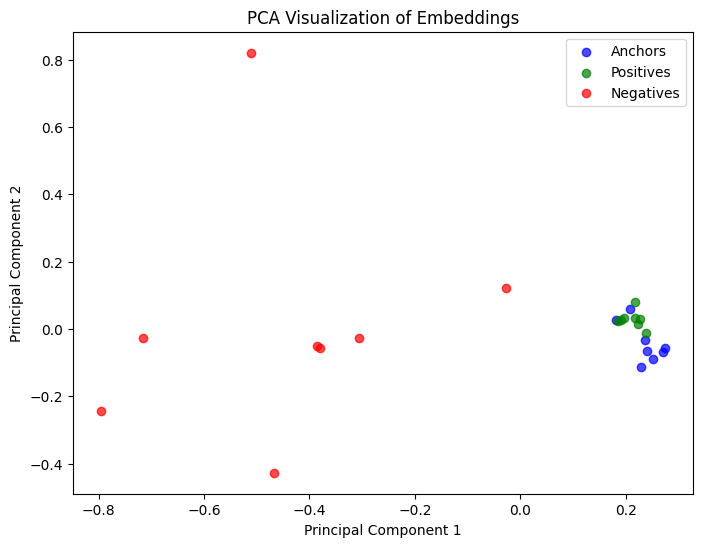

In [ ]:
# ----- PCA Visualization -----
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_embeddings[list(anchors_idx), 0], pca_embeddings[list(anchors_idx), 1], c='blue', label='Anchors', alpha=0.7)
plt.scatter(pca_embeddings[list(positives_idx), 0], pca_embeddings[list(positives_idx), 1], c='green', label='Positives', alpha=0.7)
plt.scatter(pca_embeddings[list(negatives_idx), 0], pca_embeddings[list(negatives_idx), 1], c='red', label='Negatives', alpha=0.7)
plt.legend()
plt.title("PCA Visualization of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

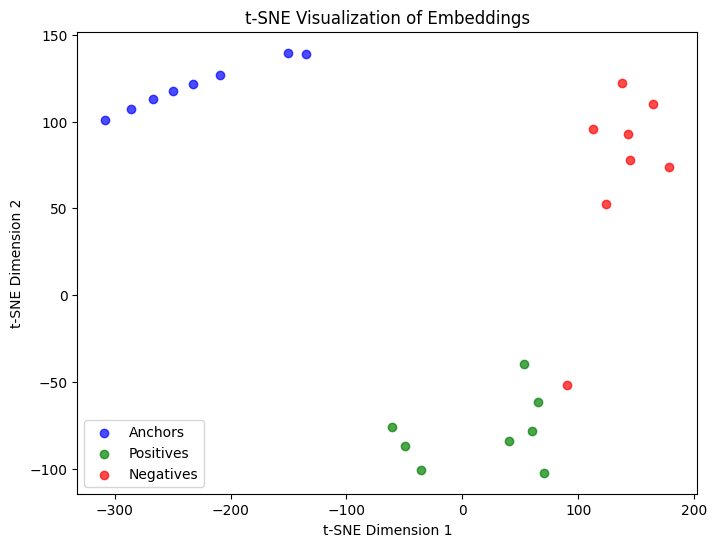

In [ ]:
# ----- t-SNE Visualization -----
# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=2, random_state=42)  # Ensure perplexity is < number of samples
tsne_embeddings = tsne.fit_transform(all_embeddings)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[list(anchors_idx), 0], tsne_embeddings[list(anchors_idx), 1], c='blue', label='Anchors', alpha=0.7)
plt.scatter(tsne_embeddings[list(positives_idx), 0], tsne_embeddings[list(positives_idx), 1], c='green', label='Positives', alpha=0.7)
plt.scatter(tsne_embeddings[list(negatives_idx), 0], tsne_embeddings[list(negatives_idx), 1], c='red', label='Negatives', alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [ ]:
# Evaluate accuracy
def calculate_embeddings(created_model, images):
    return created_model.predict(images)

In [ ]:
anchor_embeddings = calculate_embeddings(created_model, anchors)
positive_embeddings = calculate_embeddings(created_model, positives)
negative_embeddings = calculate_embeddings(created_model, negatives)

# DEBUG: Print shapes before calculations
print(f"Anchor shape: {anchor_embeddings.shape}")
print(f"Positive shape: {positive_embeddings.shape}")
print(f"Negative shape: {negative_embeddings.shape}")

# Calculate distances
positive_distances = tf.norm(anchor_embeddings - positive_embeddings, axis=1)
negative_distances = tf.norm(anchor_embeddings - negative_embeddings, axis=1)

# Check distances
print(f"Positive distances: {positive_distances}")
print(f"Negative distances: {negative_distances}")

# Calculate accuracy based on threshold
accuracy = tf.reduce_mean(tf.cast(positive_distances < negative_distances - 0.45, tf.float32))

1/1 [==============================] - 2s 2s/step
Anchor shape: (8, 128)
Positive shape: (8, 128)
Negative shape: (8, 128)
Positive distances: [0.2896486  0.25364602 0.36556816 0.28856182 0.26856467 0.29327622
 0.3008999  0.2556481 ]
Negative distances: [0.8023303  0.70718515 1.0893219  1.1136439  0.7183948  0.86505437
 1.1322842  0.89600533]


In [ ]:
print(accuracy)

tf.Tensor(0.875, shape=(), dtype=float32)


In [ ]:
def plot_distances(positive_distances, negative_distances):
    """
    Plot the distribution of distances for positive and negative pairs.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(positive_distances, bins=30, alpha=0.7, label='Positive Pairs', color='green')
    plt.hist(negative_distances, bins=30, alpha=0.7, label='Negative Pairs', color='red')
    plt.axvline(0.4, color='blue', linestyle='--', label='Threshold (0.4)')
    plt.title("Distance Distribution for Positive and Negative Pairs")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    # Saving the figure.
    plt.savefig("Face_Recognition_graph.png")

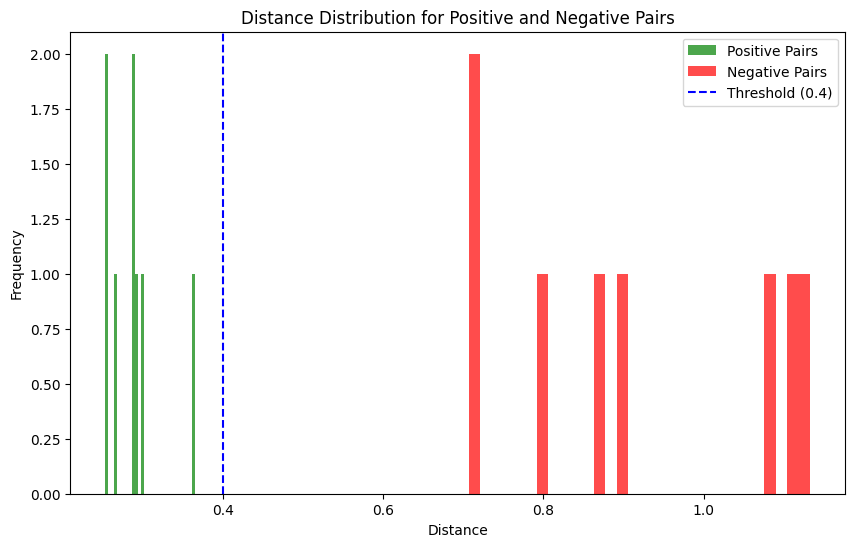

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_distances(positive_distances, negative_distances)

**---------------- END OF CODE ----------------**